# Team E - Pixels plus domain knowledge to True Shower parameters with CNNs

## Team Members

* Bjarne Karsten (3559535)
* Marek Freunscht (9604914)
* Florian Hartung (6622800)

## Data and Example Download
[...]

* an exemplary jupyter notebook and futher information is available from the git repo https://github.com/astrojarred/magic-ml-images
    * You find more information there. 


## TASK 

* Improve your understanding of the data 
* The focus of this teams is the setup of MLPs or CNNs and combining them with domain knowledge like the hillas parameters
* Use the pixel information features starting "clean_image" and the features starting with "hillas" and "stereo"
    * they contain information of all the pixels for a simulated particle
        * "clean_image" contains the data after some some standard cleaning algorithms were applied. These data are used in the MAGIC analysis to derive the Hillas Parameters.
        * "hillas" and "stereo" features are derived from the raw images by using the standard MAGIC analysis workflow. 
* Create a baseline using a simple ML algorithm to
    * classify gammas and protons 
        * by combining both clean_image_\* features
        * by combining both clean_image_\* features with "hillas" and/or "stereo" 
    * predict/infer the true shower parameters using a simple ML algorithm
        * using clean_image\_\*\_m1 and clean_image\_\*\_m2 independently
        * by combining both clean_image_\* features with "hillas" and/or "stereo" 
* Use MLP and simple CNN networks following the same strategy as above to
    * classify gammas and protons 
    * predict/infer true shower parameters using a simple ML algorithm
    * Think about a method to reuse the existing CNN kernels instead of using a hexagonal approch
* compare the different approaches 




## Implementation
TODO documentation

- present project structure
    - **this notebook**
    - `src/`
        - `common/`: Common python modules for this notebook and other modules
            - `__init__.py`: Lists of grouped feature names like `FEATURES_HILLAS`, `FEATURES_STEREO` or `FEATURES_IMAGE_M1`
            - `data_loading.py`: TODO
            - `preprocessing.py`: TODO
            - `HexaToParallelogramm.py`: TODO
            - `batch.py`: TODO maybe remove this module?
        - `classification_gammas_protons/`: TODO
        - `infer_true_shower_parameters/`: TODO
    - `magic-ml-images/`: TODO
    - `data/`: Parquet files

- present structure of this notebook + instructions how to evaluate, train, save and load individual models
    - notebook initialization
    - common dataloading for all models used
    - classification models
        - preprocess data for classification
        - classification baseline #1
        - classification baseline #2
        - classification baseline #3
        - advanced classification model #1
        - advanced classification model #2
        - advanced classification model #3
    - regression models
        - preprocess data for regression
        - regression baseline #1
        - regression baseline #2
        - regression baseline #3
        - advanced regression model #1
        - advanced regression model #2
        - advanced regression model #3


### Initialize notebook
First we load the `magicdl` module, which resides in `./magic-ml-images` as a git submodule (<https://github.com/astrojarred/magic-ml-images>).

Also we set some global configuration variables and select an appropriate torch device.

In [4]:
import sys
from pathlib import Path
import torch

# Load magicdl module
module_path = str(Path.cwd() / "magic-ml-images")
if module_path not in sys.path:
    sys.path.append(module_path)
import magicdl.magic

# The parent directory of all dataset parquet files
DATA_DIR = Path.cwd() / "data"

# The parent directory of where trained models are saved to and loaded from
TRAINED_MODELS_DIR = Path.cwd() / "trained_models"
TRAINED_MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Whether models trained from this notebook are saved automatically
SAVE_MODELS_AFTER_TRAINING = True

# Select torch device globally. This is later passed to all train/evaluate functions
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using torch device '{torch_device}'")

# The seed used for all RNG in data preprocessing and models.
# IMPORTANT: When this seed is changed, one must not load any models trained
#            and saved with a previous different seed. Doing so would violate
#            the ML process, because the previous training/validation data
#            could now end up in the test dataset.
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

Using torch device 'cpu'


### Dataloading
We have defined a module for loading both proton and gamma datasets.
Our dataloading also flattens the image columns, so that every image column is converted to 1039 (number of pixels) individual columns each with a scalar value.
This should not have any impact on performance or memory footprint (TODO Why?), but it allows models to use images as features more easily.

In this step we also add class labels for both datasets.


In [10]:
from src.common import *
from src.common.data_loading import load_dataset_and_flatten_images

# We choose to only load relevant images and features to save memory
FEATURES_TO_LOAD = FEATURES_HILLAS + FEATURES_STEREO + FEATURES_TRUE_SHOWER
IMAGES_TO_LOAD = ["clean_image_m1", "clean_image_m2"]

# Load the datasets
data_gammas_raw = load_dataset_and_flatten_images(
    DATA_DIR / "magic-gammas-new-4.parquet", IMAGES_TO_LOAD, FEATURES_TO_LOAD
)
data_protons_raw = load_dataset_and_flatten_images(
    DATA_DIR / "magic-protons.parquet", IMAGES_TO_LOAD, FEATURES_TO_LOAD
)

ArrowMemoryError: realloc of size 536870912 failed

### Strategies

The hexagon needs to be brought in a convolvable shape. To achieve this, we complete it to a parallelogram. This way, we can convolve along the horizontal and the diagonal.

In [5]:
lt = magicdl.magic.Geometry.lookup_table()
qs, rs = (list(t) for t in zip(*lt.keys()))

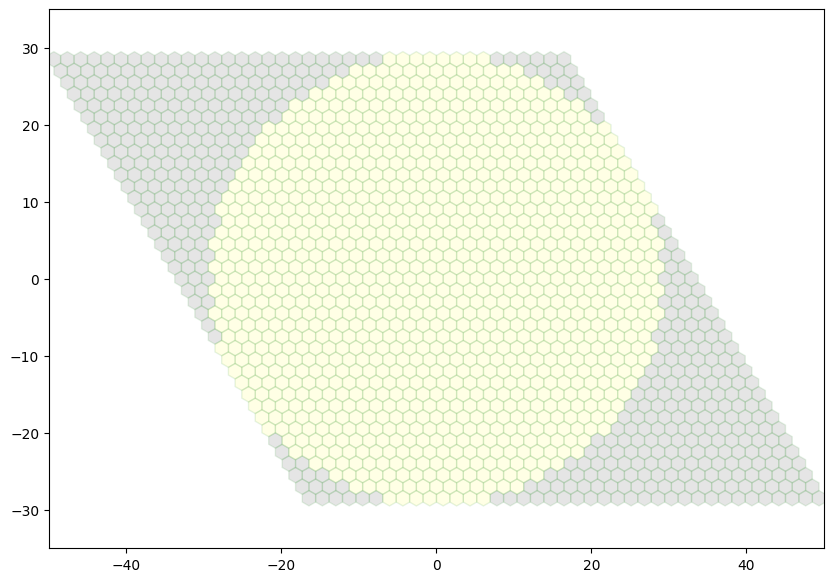

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

figsize = (10, 7)
plt.figure(figsize=figsize)
size = 1

ax = plt.gca()

for q in range(-19, 20):
    for r in range(-19,20):
        ax.add_patch(
            RegularPolygon(
                (magicdl.magic.Geometry.pointy_hex_to_pixel(q,r)),
                6,
                radius=size,
                facecolor= "yellow" if (q,r) in lt.keys() else "black",
                edgecolor="green",
                alpha=0.1,
            )
        )
plt.xlim(-50, 50)
plt.ylim(-35, 35)
plt.show()

Es wird eine Torch-Schicht implementiert, die eine eindimensionale Liste an Pixeln entgegegennimmt und einen Torch-Tensor weitergibt. Dieser ist zunächst mit einem vorher gegebenen Padding-Wert aufgefüllt. Es werden daraufhin die gegebenen Werte gemäß der Logik des Magic-Moduls eingefügt. Dabei werden q und r, die Koordinaten in der Hexagonaldarstellung, als x und y reinterpretiert. Hier ist der Padding-Wert zur Veranschaulichung negativ:

We implement a torch layer that takes tensor where the pixels are given along one dimension and passes forth a tensor where they are given two-dimensionally. The image is first filled with a given padding value. Then the given pixel values are filled in according to the logic of the magicdl module. Here q and r, the hexagonal coordinates, are reinterpreted as x and y. In the following, the padding is negative for visualisation purposes:

In [ ]:
from src.common.HexaToParallelogram import HexaToParallelogram

p = data_protons_raw[FEATURES_CLEAN_IMAGE_M1].iloc[0].tolist()

h = HexaToParallelogram(0, -20)
result = h.forward(p)

plt.imshow(result.numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

### Data preprocessing for classification models
*Note: this cell need to be run only for classification models*

In [3]:
from src.common.preprocessing import preprocess
import pandas as pd

# Assign binary class labels
data_gammas_raw["class"] = 0.0
data_protons_raw["class"] = 1.0

# Concat both datasets. There is not need to shuffle, as that will be done by torch Dataloaders automatically
data_classification = pd.concat([data_gammas_raw, data_protons_raw])

normalize_params = (
    FEATURES_HILLAS
    + FEATURES_STEREO
    + FEATURES_TRUE_SHOWER
    + FEATURES_CLEAN_IMAGE_M1
    + FEATURES_CLEAN_IMAGE_M2
)

data_classification_train, data_classification_validation, data_classification_test = (
    preprocess(
        data_classification,
        normalize_params=normalize_params,
        stratify_column_name="class",
        train_portion=0.7,
        validation_portion=0.2,
        seed=SEED,
    )
)

## Model: Classification with CNN with Hillas
This model uses a CNN combined with a fully-connected neural network to classify protons and gamma particles.
It feeds both cleaned images (`clean_image_m1` & `clean_image_m2`) into a CNN, then concatenates its output with the hillas parameters and feeds those into the deep neural network, which then in turn outputs a single scalar value.

The final layer does not use a sigmoid function itself, as this is not recommended for binary classification (TODO source?).

In [5]:
import src.classification_gammas_protons.cnn as classification_cnn

TRAIN_THIS_MODEL = True
THIS_MODEL_NAME = "classification_cnn_with_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = None
if TRAIN_THIS_MODEL:
    model = classification_cnn.train(
        data_classification_train,
        data_classification_validation,
        image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
        additional_features=FEATURES_HILLAS,
        class_feature="class",
        device=torch_device,
        epochs=2,
    )

    if SAVE_MODELS_AFTER_TRAINING:
        classification_cnn.save(model, trained_model_path)
else:
    model = classification_cnn.load(trained_model_path, additional_features=FEATURES_HILLAS)

# TODO: Evaluate model on test data, maybe also show training/validation plots

Epoch 1/2 - Train Loss: 0.44480210 Acc: 0.79014318 | Val Loss: 0.41117360 Val Acc: 0.81838717 | Epoch took 161.62s
Epoch 2/2 - Train Loss: 0.39031975 Acc: 0.82115025 | Val Loss: 0.37634924 Val Acc: 0.83442512 | Epoch took 160.07s


### Data preprocessing for regression models
*Note: this cell only need to be run for all regression models*

In [ ]:
from src.common.preprocessing import preprocess
import pandas as pd

normalize_params = (
    PARAMS_HILLAS
    + PARAMS_STEREO
    + PARAMS_TRUE_SHOWER
    + PARAMS_CLEAN_IMAGE_M1
    + PARAMS_CLEAN_IMAGE_M2
)

(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    data_regression_gammas_test,
) = preprocess(
    data_gammas_raw,
    normalize_params=normalize_params,
    train_portion=0.7,
    validation_portion=0.2,
    seed=SEED,
)

(
    data_regression_protons_train,
    data_regression_protons_validation,
    data_regression_protons_test,
) = preprocess(
    data_protons_raw,
    normalize_params=normalize_params,
    train_portion=0.7,
    validation_portion=0.2,
    seed=SEED,
)